# Understanding Who AGM's Best Customers Are 

In [1]:
# Import necessary packages
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    '''This function will run a selected query in Postgres and 
    return the rows in a pandas dataframe'''
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # Below converts float columns that integer columns, for those that should be integer columns.
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

##### First we will conduct some general queries to get an idea of the scale of AGM's customer base (including those that have not yet contributed to sales).

In [3]:
# Count Total Number of Registered Customer IDs to get an idea of scale of AGM's customer base 

rollback_before_flag = True
rollback_after_flag = True

query = """
select count(distinct customer_id) as distinct_customers
from customers

"""
print('Table 1: Total Number of AGM\'s Distinct Customers')
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

Table 1: Total Number of AGM's Distinct Customers


,distinct_customers
0,31082


In [4]:
# Count Total Number of Customer IDs contributing to sales to see how many of the registered customers are buying meals

rollback_before_flag = True
rollback_after_flag = True

query = """
select count(distinct customer_id) as distinct_customers
from sales

"""
print('Table 2: Total Number of AGM\'s Distinct Customers contributing to AGM\'s Sales')
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)

Table 2: Total Number of AGM's Distinct Customers contributing to AGM's Sales


,distinct_customers
0,31047


Of the 31,082 registered customers, 31,047 have made a purchase. This means that there are 35 people who either have registered their information with AGM or are potentially errors in the database or fake customers that AGM could have created in the beginning when testing their SQL database, but forgot to take out. 

##### We will then investigate the number of sales-contributing customers by store. 

In [5]:
# Count Total Number of Customer IDs contributing to sales by store to see the breakdown

rollback_before_flag = True
rollback_after_flag = True

query = """
select stores.city, count(distinct sales.customer_id) as distinct_customers
from sales
join stores
     on stores.store_id = sales.store_id
group by stores.city 
order by distinct_customers desc
"""
print('Table 3: Number of Distinct Customers by Store')
my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)


Table 3: Number of Distinct Customers by Store


,city,distinct_customers
0,Berkeley,8126
1,Seattle,7206
2,Dallas,6355
3,Miami,5720
4,Nashville,3640


The AGM store in Berkeley seems to have the highest number of distinct customers, followed by Seattle. Nashville seems to be the lowest. 

Given that no information has been given on how and when AGM expanded to the different cities, nothing can be said about how this may have affected these numbers (e.g. we cannot assume that Nashville is new).

##### Next we will investigate to determin who AGM's top customers are, where they are based.

In [21]:
# See which customers have been contributing the most and least to AGM's sales

rollback_before_flag = True
rollback_after_flag = True

query = """
select sales.customer_id, stores.city, count(distinct sales.sale_id) as distinct_sales, sum(sales.total_amount) as total_amount_sales
from sales
join stores
     on stores.store_id = sales.store_id
group by customer_id, stores.city
order by total_amount_sales desc
"""

df_cs = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
print('Table 4: Number of Sales and Total Sale Amounts by Customer')
df_cs


Table 4: Number of Sales and Total Sale Amounts by Customer


,customer_id,city,distinct_sales,total_amount_sales
0,30772,Nashville,110,8328
1,30775,Nashville,108,7908
2,30692,Nashville,100,7860
3,30323,Nashville,106,7848
4,28543,Nashville,108,7848
...,...,...,...,...
31042,15264,Seattle,12,708
31043,1528,Berkeley,16,684
31044,12861,Seattle,14,672
31045,22530,Miami,14,648


<function matplotlib.pyplot.show(close=None, block=None)>

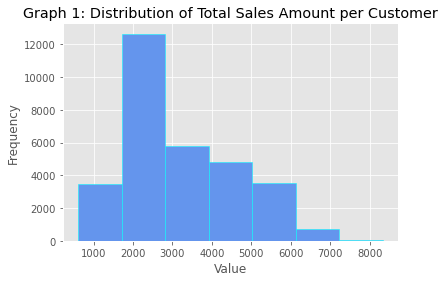

In [22]:
# Graph the distribution of the total sales amount by customers 

plt.hist(df_cs['total_amount_sales'], bins = 7, edgecolor='aqua', color='cornflowerblue')
plt.title('Graph 1: Distribution of Total Sales Amount per Customer')
plt.style.use('ggplot')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show

Based on the above distribution in Graph 1, *we decide to focus on analyzing the right two bins of customers contributing the most to AGM's sales.*

The below website gives information on how bins are calculated by matplotlib in python. Essentially the range of the values is taken and then divided by the number of desired bins. Using this information, it was possible to calculate the values in the different bins which is helpful in this analysis. 

https://www.geeksforgeeks.org/bin-size-in-matplotlib-histogram/

In [23]:
# Calculating Bin Ranges

range1 = 8328-612
binz = round(range1/7, 2)
print('Individual bin size:','$', binz)

print()

bin2a = round(612 + binz, 2)
bin2b = round(binz + bin2a, 2)
print('Bin 2:')
print('$',bin2a, '-','$', bin2b)

print()

print('Bins 6 and 7')
bin6a = round(612+(binz*5), 2)
bin7a = round(bin6a+binz, 2)
bin7b = round(bin7a+binz, 2)
print('$', bin6a,'-', '$', bin7b)


Individual bin size: $ 1102.29

Bin 2:
$ 1714.29 - $ 2816.58

Bins 6 and 7
$ 6123.45 - $ 8328.03


Given the above information, we will define the best customers to be those who have spend at least '$6,123.45' at AGM. The following analysis will investigate further on this sample of customers. 

In [24]:
# Query the top customers
rollback_before_flag = True
rollback_after_flag = True

query = """
select sales.customer_id, stores.city, count(distinct sales.sale_id) as distinct_sales, sum(sales.total_amount) as total_amount_sales
from sales
join stores
     on stores.store_id = sales.store_id 
group by customer_id, stores.city
having sum(sales.total_amount) >= 6123
order by total_amount_sales desc
"""

df_cs_top = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
print(('Table 5: Top Customers of AGM'))
df_cs_top


Table 5: Top Customers of AGM


,customer_id,city,distinct_sales,total_amount_sales
0,30772,Nashville,110,8328
1,30775,Nashville,108,7908
2,30692,Nashville,100,7860
3,30323,Nashville,106,7848
4,28543,Nashville,108,7848
...,...,...,...,...
800,25343,Miami,90,6132
801,17129,Dallas,100,6132
802,7900,Berkeley,93,6132
803,28979,Nashville,100,6132


In [25]:
# Proportion of AGM's Top Customers from its sales-contributing customer base
805/31047

0.02592843108834992

Table 5 tells us that under our definition of the top customers, of the 31,047 distinct customers that have contributed to AGM sales, 805 are considered as the best. This is about 2.6% of AGM's sales-contributing customers. 

In [26]:
# Calculate the Number of Top Customers in each Store

df_cs_top['number_customers']=df_cs_top['customer_id']
df2 = df_cs_top[['city', 'number_customers']]
print('Table 6: Number of Top customers by Store')
df2.groupby('city').count()

Table 6: Number of Top customers by Store


,number_customers
city,
Berkeley,18
Dallas,80
Miami,86
Nashville,526
Seattle,95


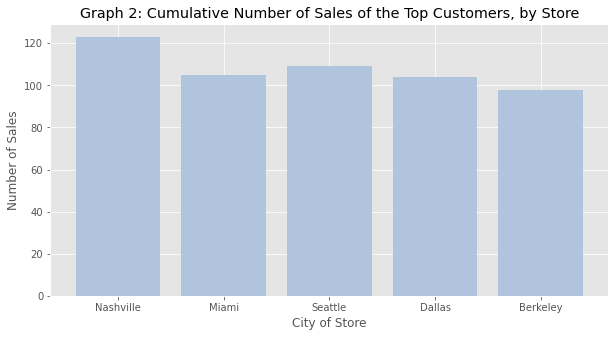

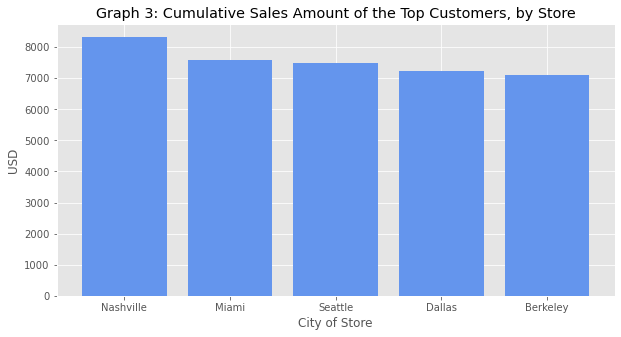

In [27]:
# Graph the distribution of stores the top customers shop at

# By number of sales
plt.figure(figsize=(10,5))
plt.bar(df_cs_top['city'], df_cs_top['distinct_sales'], color='lightsteelblue')
plt.title('Graph 2: Cumulative Number of Sales of the Top Customers, by Store')
plt.xlabel('City of Store')
plt.ylabel('Number of Sales')
plt.show()

# By total sales amount 
plt.figure(figsize=(10,5))
plt.bar(df_cs_top['city'], df_cs_top['total_amount_sales'], color='cornflowerblue')
plt.title('Graph 3: Cumulative Sales Amount of the Top Customers, by Store')
plt.xlabel('City of Store')
plt.ylabel('USD')
plt.show()

In both graphs 2 and 3, it seems that Nashville had the highest number of cumulative sales by number of sales and total sales amount. Berkeley on the other hand had the lowest in both cases. Considering that Berkeley had the highest number of registered customers contributing to sales (8,126) and Nashville had the lowest (3,640) according to Table 1, this is quite intriguing. It suggests that while Nashville may have the least number of overall customers, it has the most "top customers" contributing to AGM's sales. This is supported by table 6 which shows that of the 805 top customers, 526 (~65%) come from Nashville's store. Considering Nashville's customer base is less than half the size of Berkeley's this is relatively impressive. 

What is also interesting to note is that even though the cumulative sales of Berkeley is relatively the lowest of all the stores (by both number of sales and total sales amount), the fact that this has been contributed by only 18 top customers (i.e. ~2% of all top customers) is quite impressive. It implies that while the Berkeley may have the least number of top customers, these top customers are likely some of the most loyal and returning customers of AGM. This also suggests that Berkeley's customer base may have less people returning at the rate Nashville has been seeing.

Dallas, Seattle, and Miami also had much lower numbers of top customers but not as low as Berkeley; theirs ranged between 80-95 top customers each. Given this, it is still relatively impressive that these stores' top customers have also been able to have cumulative sales not too far off from Nashville's. 

In [28]:
# Investigate how far away customers tend to travvel to pick up their AGM meal 

rollback_before_flag = True
rollback_after_flag = True

query = """
select sales.customer_id, stores.city, stores.store_id, customers.closest_store_id, avg(customers.distance) as avg_distance
from sales
join stores
     on stores.store_id = sales.store_id 
join customers
     on customers.customer_id = sales.customer_id
group by sales.customer_id, stores.city, stores.store_id, customers.closest_store_id, customers.distance
having sum(sales.total_amount) >= 6123
order by customers.distance desc
"""

df_cs_top2 = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
print('Table 7: Distance Top Customers are traveling to pick up their AGM Meal')
df_cs_top2

Table 7: Distance Top Customers are traveling to pick up their AGM Meal


,customer_id,city,store_id,closest_store_id,avg_distance
0,15326,Seattle,2,2,25
1,21691,Dallas,3,3,24
2,21673,Dallas,3,3,23
3,27399,Miami,4,4,23
4,27417,Miami,4,4,23
...,...,...,...,...,...
800,27590,Nashville,5,5,1
801,27596,Nashville,5,5,1
802,27598,Nashville,5,5,1
803,27605,Nashville,5,5,1


In [29]:
# Based on Table 6, calculate the aveerage distance customers are travelling to get their AGM meal 

df2 = df_cs_top2[['city', 'avg_distance']]
print('Table 8: Average Distance Top Customers are Traveling to pick up their AGM meal, by Store')
df2.groupby('city').mean()

Table 8: Average Distance Top Customers are Traveling to pick up their AGM meal, by Store


,avg_distance
city,
Berkeley,10.722222
Dallas,8.175
Miami,8.581395
Nashville,4.359316
Seattle,9.757895


Table 7 above shows that on average, top customers near the Berkeley store (followed by Seattle) have been traveling the most distance to get to the grocery store hosting their AGM meals, at ~10 miles (assumed miles given context; not specified in database description). Nashville on the other hand had the lowest top customer distance averge at ~4.4 miles. Given that on average, customers in Nashville seem to be travelling less it explains why even with a smaller overall customer base, the Nashville store has been able to accumulate a larger top customer base. It requires less effort on the part of a top customer in Nashville to purchase their AGM meal on average, compared to someone in Berkeley. 

### Characteristics of Top Customers based on Above Analysis:
- Those who spent at least $6,123 in 2020 on AGM meals.  
- Those based in areas requiring less travel to AGM hosted grocery stores. 

**To tap in more into what other characteristics make up top customers, the following supplementary research would be suggested:**
Conduct greater research on the exact location of where each store is in these cities and compare the surround neighborhoods of each store. This would involve getting secondary data on the following surrounding neighborhoods: income distributions, number of business spaces (or higher education facilities) in the neighborhood, number of people working per business space, number of residential units, and population broken down by age groups. Together, this information would help get a clearer picture of the traits these top customers are, and why Nashville has been able to have the most top customers, despite having the smallest customer base. This proposition would help AGM get better insight to inform their strategy to see how more customers can join their top customers group from more stores. 